In [2]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import re
import seaborn as sns
from matplotlib import gridspec
from datetime import datetime, timedelta
import statsmodels.api as sm

In [3]:
# Create a DataFrame with the provided data
data = pd.read_csv("NSEI.csv",header=None)
column_name = ["Symbol", "Date", "Time", "Open", "High", "Low", "Close", "Volume", "OpenInterest"]
data.columns = column_name

In [4]:
data.head()

Symbol        Date   Time     Open     High      Low    Close  Volume  \
0  .NSEI  2022/01/03  09:15  17393.2  17439.5  17383.3  17428.4       0   
1  .NSEI  2022/01/03  09:16  17431.0  17452.8  17430.6  17450.1       0   
2  .NSEI  2022/01/03  09:17  17448.2  17460.4  17442.1  17455.9       0   
3  .NSEI  2022/01/03  09:18  17455.6  17466.1  17455.3  17465.3       0   
4  .NSEI  2022/01/03  09:19  17463.9  17475.8  17462.2  17470.9       0   

   OpenInterest  
0             0  
1             0  
2             0  
3             0  
4             0

In [5]:
data["DateTime"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data.set_index("DateTime", inplace=True)

#### Calculation of ATR:
* KEY:
	- CC : Current Candle
	- PC : Previous Candle
	- H  : High
	- L  : Low
	- CP : Previous Candle Close
	- n  : Period

#### TR Values

1. Calculate the TR (True range):
	- TR = max(a,b,c)
        - where a,b,c are:
			- a = CC High (H) - CC Low (L)
			- b = Absolute[ CC High (H) - PC Close (CP) ]
			- c = Absolute[ PC Close (CP) - CC Low (L) ]

2. Starting TR value = First Candle's (H - L)

#### ATR Values 

- Generally ATR has a period of 14 days
    * n = 14

3. Starting ATR = (TR1 + TR2 + TR3 + .... + TRn)/n  
        This is the simply the avg of TR over the first period


4. Current Period ATR = (Prior Period ATR(n-1) + Current Period TR)/n

In [6]:
# ATR calculation function
def calculate_atr(data, n=14):
    tr_values = []
    atr_values = []
    for i in range(len(data)):
        if i == 0:
            tr = data['High'][i] - data['Low'][i]
        else:
            a = data['High'][i] - data['Low'][i]
            b = abs(data['High'][i] - data['Close'][i - 1])
            c = abs(data['Close'][i - 1] - data['Low'][i])
            tr = max(a, b, c)
        tr_values.append(tr)
        if i < n:
            atr_values.append(sum(tr_values) / (i + 1))
        else:
            atr_values.append((atr_values[-1] * (n - 1) + tr) / n)
    return atr_values

In [7]:
def calculate_srp(data):
    data['Pivot'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['Resistance_1'] = (2 * data['Pivot']) - data['Low']
    data['Support_1'] = (2 * data['Pivot']) - data['High']
    data['Resistance_2'] = data['Pivot'] + (data['High'] - data['Low'])
    data['Support_2'] = data['Pivot'] - (data['High'] - data['Low'])
    data['Resistance_3'] = data['High'] + 2 * (data['Pivot'] - data['Low'])
    data['Support_3'] = data['Low'] - 2 * (data['High'] - data['Pivot'])

In [8]:
def calculate_30min(data):
    minutes = data["Time"].str.extract(r'\d{2}:(\d{2})')
    list_30 = [i for i in range(minutes.shape[0]) if minutes.iloc[i].values[0] == '30' or 
               minutes.iloc[i].values[0] == '00']
    n = 0
    for dt_idx in data.index:
        data.loc[dt_idx, '30_min'] = n
        if dt_idx.minute in [0, 30]:
            n += 30
def calculate_3D(data):
    n = 0
    for i, dt_idx in enumerate(data.index):
        data.loc[dt_idx, 'day_3'] = n
        if (i + 1) % 3 == 0:
            n += 3
def calculate_hour(data):
    n = 0
    prev_hour = None
    data_copy = data.copy()
    for dt_idx in data_copy.index:
        current_hour = dt_idx.hour
        if current_hour != prev_hour:
            n += 1
        data_copy.loc[dt_idx, 'Hour'] = n
        prev_hour = current_hour
    data['Hour'] = data_copy['Hour']
def calculate_biweekly(df):
    df['Biweekly Number'] = 0
    biweekly_number = 1
    start_date = df.index.min()
    for index, row in df.iterrows():
        if (index - start_date).days >= 14:
            biweekly_number += 1
            start_date = index
        df.at[index, 'Biweekly Number'] = biweekly_number

In [9]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Filter data for one month (e.g., January 2022)
start_date = '2022-02-01'
end_date = '2022-02-10'
df_resampled = data[start_date:end_date]

# Create the candlestick chart using Plotly
fig_candlestick = go.Figure(data=[go.Candlestick(
    x=df_resampled.index,
    open=df_resampled['Open'],
    high=df_resampled['High'],
    low=df_resampled['Low'],
    close=df_resampled['Close']
)])

df_resampled['ATR'] = calculate_atr(df_resampled)
# Create the ATR plot using Plotly
fig_atr = go.Figure()
fig_atr.add_trace(go.Scatter(x=df_resampled.index, y=df_resampled['ATR'], mode='lines', name='ATR'))
# Create a subplot with shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(fig_candlestick.data[0], row=1, col=1)

for trace in fig_atr.data:
    fig.add_trace(trace, row=2, col=1)

# Update layout
fig.update_layout(
    title='Candlestick Chart and ATR Values',
    xaxis_rangeslider_visible=True,
    xaxis=dict(type='category', categoryorder='category ascending'), 
    xaxis2=dict(type='category', categoryorder='category ascending'),
)

# Link the x-axes of the two subplots
fig.update_xaxes(matches='x')

# Set the custom x-axis tick values and labels
tickvals = df_resampled.index[::int(len(df_resampled.index) / 10)]
ticktext = tickvals.strftime('%Y-%m-%d %H:%M')
fig.update_xaxes(row=2, col=1, tickvals=tickvals, ticktext=ticktext, tickangle=45) 

# Display the combined subplot
fig.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_11540\2203702077.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- 1 yr ----- w
- 3 month ---- 1 hr
- 1 month --- 30 min
- 5 day --- 5 min
- 1 day --- 1 min


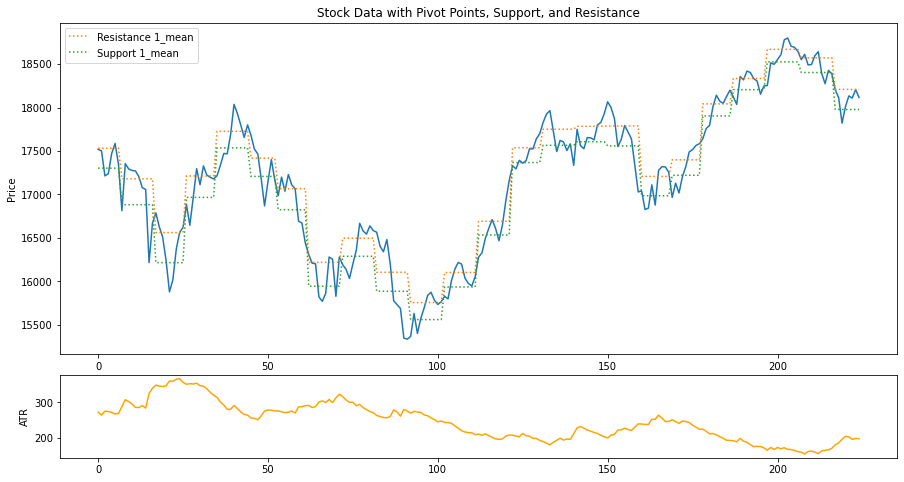

In [10]:
def plot_stock_data(data_orig, start_date, period):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    period_to_timedelta = {
    '1Y': timedelta(days=365),
    '12M': timedelta(days=365),
    '10M': timedelta(days=305),
    '6M': timedelta(days=183),
    '3M': timedelta(days=91),
    '1M': timedelta(days=30),
    'M': timedelta(days=30),  
    '5D': timedelta(days=5),
    'D': timedelta(days=1)
    }
    if period in period_to_timedelta:
        # Map user input string to timedelta
        period_timedelta = period_to_timedelta[period]
        
        end_date = start_date + period_timedelta
        end_date = end_date.strftime('%Y-%m-%d')

    if period_timedelta > timedelta(days=305) and period_timedelta == timedelta(days=365):
        n=1
        span_sr = 'Biweekly Number'
        span_atr = 'D'
    elif period_timedelta >= timedelta(days=183) and period_timedelta <= timedelta(days=305):
        n=2
        span_sr = 'Biweekly Number'
        span_atr = '2H'
    elif period_timedelta >= timedelta(days=91) and period_timedelta < timedelta(days=183):
        n=3
        span_sr = 'Week'
        span_atr = 'H'
    elif period_timedelta >= timedelta(days=30) and period_timedelta < timedelta(days=91):
        n=2
        span_sr = 'Date'
        span_atr = '30T'
    elif period_timedelta >= timedelta(days=5) and period_timedelta < timedelta(days=30):
        n=1
        span_sr = 'Hour'
        span_atr = '5T'
    elif period_timedelta >= timedelta(days=1) and period_timedelta < timedelta(days=5):
        n=1
        span_sr = '30_min'
        span_atr = 'T'
    
    data = data_orig.resample(span_atr).agg({
        'Date': 'first',
        'Time': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    })
    data.dropna(axis=0, inplace=True)
    
    calculate_srp(data)
    
    data['Week'] = data.index.isocalendar().week
    data['Month'] = data.index.month
    data['Minute'] = data.index.minute
    if span_sr == '30_min':
        calculate_30min(data)
    elif span_sr == 'Hour':
        calculate_hour(data)
    elif span_sr == 'Biweekly Number':
        calculate_biweekly(data)
    
    
    data['ATR'] = calculate_atr(data)
    
    df_resampled = data[start_date:end_date]
    df_resampled.reset_index(inplace=True)
    
    group_data = df_resampled.groupby(span_sr).mean()[['Pivot','Resistance_1',
                                                'Support_1','Resistance_2','Support_2',
                                                      'Resistance_3','Support_3']]
    
    df_resampled = df_resampled.join(group_data,on=span_sr,rsuffix='_mean')
    
    # Create subplots
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0.1)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharex=ax1)
    
    # Plot 'Close' values
    sns.lineplot(data=df_resampled, y='Close', x=df_resampled.index, ax=ax1)
    
    # Plot pivot points, support, and resistance levels
#     ax1.plot(df_resampled.index, df_resampled['Pivot_mean'], label='Pivot_mean', linestyle='--')
    if n==1:
        ax1.plot(df_resampled.index, df_resampled['Resistance_1_mean'], label='Resistance 1_mean', linestyle=':')
        ax1.plot(df_resampled.index, df_resampled['Support_1_mean'], label='Support 1_mean', linestyle=':')
    elif n==2:
        ax1.plot(df_resampled.index, df_resampled['Resistance_2_mean'], label='Resistance 2_mean', linestyle='-.')
        ax1.plot(df_resampled.index, df_resampled['Support_2_mean'], label='Support 2_mean', linestyle='-.')
    elif n==3:
        ax1.plot(df_resampled.index, df_resampled['Resistance_3_mean'], label='Resistance 3_mean', linestyle='-.')
        ax1.plot(df_resampled.index, df_resampled['Support_3_mean'], label='Support 3_mean', linestyle='-.')
    
    ax1.set_ylabel('Price')
    ax1.set_title('Stock Data with Pivot Points, Support, and Resistance')
    ax1.legend()
    
    # Plot 'ATR' values
    sns.lineplot(data=df_resampled, y='ATR', x=df_resampled.index, ax=ax2, color='orange')
    ax2.set_ylabel('ATR')
    plt.show()

plot_stock_data(data, start_date='2022-02-03',period='1Y')


- 1 yr ----- 2w --- 1 day
- 3 month ---- 1 hr --- 1 day
- 1 month --- 30 min --- 1 day
- 5 day --- 5 min --- 1 hr
- 1 day --- 1 min --- 5 min

In [11]:
data_NSEI = pd.read_csv("NSEI.csv",header=None)
column_name = ["Symbol", "Date", "Time", "Open", "High", "Low", "Close", "Volume", "OpenInterest"]
data_NSEI.columns = column_name

data_NSEI["DateTime"] = pd.to_datetime(data_NSEI["Date"] + " " + data_NSEI["Time"])
data_NSEI.set_index("DateTime", inplace=True)

data_NSEI.drop(columns=['Volume','OpenInterest','Symbol'],inplace=True)
data_NSEI = data_NSEI.resample('T').agg({
    'Date': 'first',
    'Time': 'first',
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
})

data_NSEI.dropna(axis=0,inplace=True)

data_NSEI['ATR'] = calculate_atr(data_NSEI)
calculate_srp(data_NSEI)
calculate_biweekly(data_NSEI)
data_NSEI['Month'] = data_NSEI.index.month
group_data = data_NSEI.groupby('Month').mean()[['Pivot','Resistance_1',
                                                'Support_1','Resistance_2','Support_2',
                                                      'Resistance_3','Support_3']]
data_NSEI = data_NSEI.join(group_data,on='Month',rsuffix='_mean')

data_NSEI.drop(columns=[ 'Pivot','Resistance_1', 'Support_1',
                            'Resistance_2', 'Support_2', 'Resistance_3', 'Support_3',
                            'Month'],inplace=True)
data_NSEI.head()

Date   Time     Open     High      Low    Close  \
DateTime                                                                     
2022-01-03 09:15:00  2022/01/03  09:15  17393.2  17439.5  17383.3  17428.4   
2022-01-03 09:16:00  2022/01/03  09:16  17431.0  17452.8  17430.6  17450.1   
2022-01-03 09:17:00  2022/01/03  09:17  17448.2  17460.4  17442.1  17455.9   
2022-01-03 09:18:00  2022/01/03  09:18  17455.6  17466.1  17455.3  17465.3   
2022-01-03 09:19:00  2022/01/03  09:19  17463.9  17475.8  17462.2  17470.9   

                           ATR  Biweekly Number    Pivot_mean  \
DateTime                                                        
2022-01-03 09:15:00  56.200000                1  17761.439488   
2022-01-03 09:16:00  40.300000                1  17761.439488   
2022-01-03 09:17:00  32.966667                1  17761.439488   
2022-01-03 09:18:00  27.425000                1  17761.439488   
2022-01-03 09:19:00  24.660000                1  17761.439488   

                     Resistance_1_mean  Support_1_mean  Resistance_2_mean  \
DateTime                                                                    
2022-01-03 09:15:00       17765.636902    17757.212812       17769.863578   
2022-01-03 09:16:00       17765.636902    17757.212812       17769.863578   
2022-01-03 09:17:00       17765.636902    17757.212812       17769.863578   
2022-01-03 09:18:00       17765.636902    17757.212812       17769.863578   
2022-01-03 09:19:00       17765.636902    17757.212812       17769.863578   

                     Support_2_mean  Resistance_3_mean  Support_3_mean  
DateTime                                                                
2022-01-03 09:15:00    17753.015398       17774.060992    17748.788722  
2022-01-03 09:16:00    17753.015398       17774.060992    17748.788722  
2022-01-03 09:17:00    17753.015398       17774.060992    17748.788722  
2022-01-03 09:18:00    17753.015398       17774.060992    17748.788722  
2022-01-03 09:19:00    17753.015398       17774.060992    17748.788722

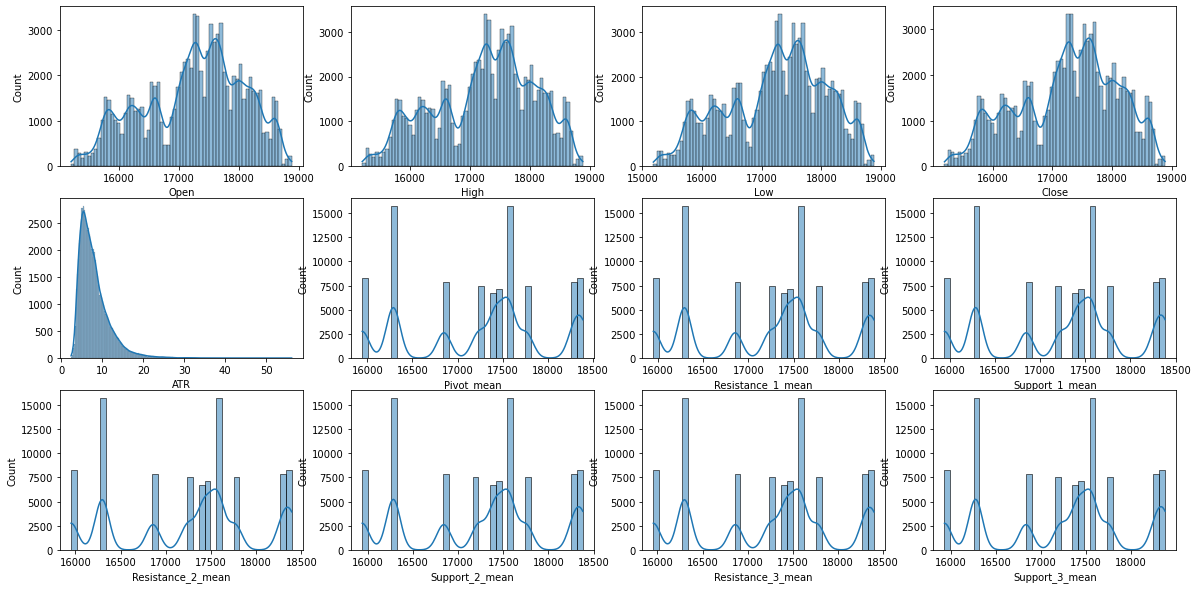

In [12]:
features = ['Open', 'High', 'Low', 'Close', 'ATR', 'Pivot_mean',
            'Resistance_1_mean', 'Support_1_mean', 'Resistance_2_mean',
            'Support_2_mean', 'Resistance_3_mean', 'Support_3_mean']
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data_NSEI[col], kde=True)
plt.show()

##### Observations:
- from OHLC curves we see that data is stable and is not varying much 
- from ATR curve we see that there is low Volatility in the data

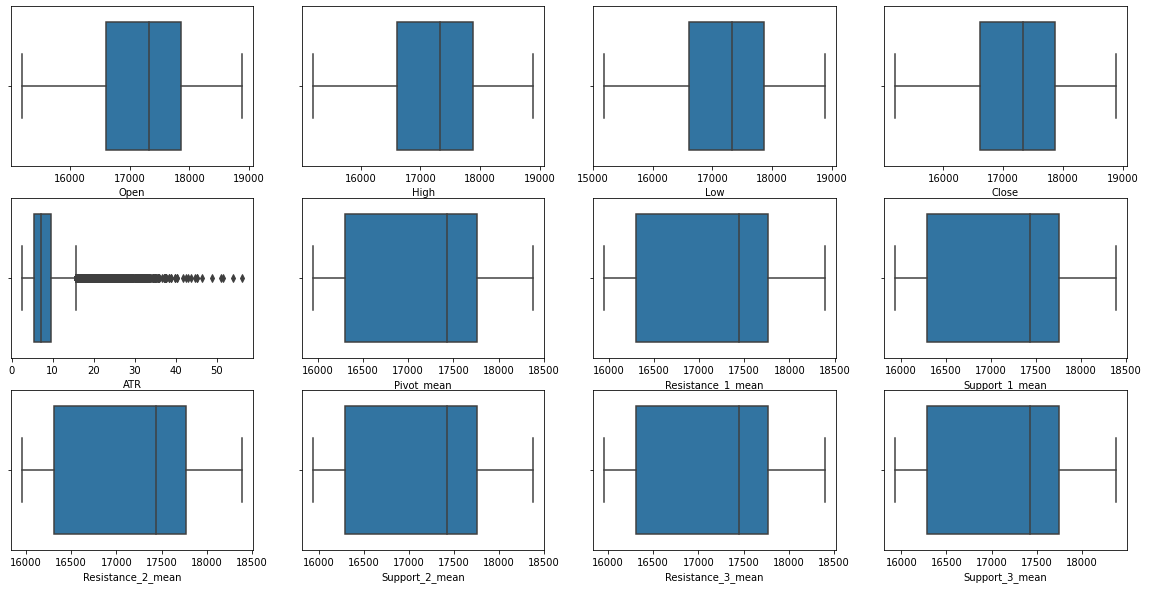

In [13]:
features = ['Open', 'High', 'Low', 'Close', 'ATR', 'Pivot_mean',
            'Resistance_1_mean', 'Support_1_mean', 'Resistance_2_mean',
            'Support_2_mean', 'Resistance_3_mean', 'Support_3_mean']
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x = data_NSEI[col])
plt.show()

##### Observations:
- from the above Boxplots we see that the data has no outliers
- from ATR curve we see that the ATR values are right skewed, also ATR values are low throughout

In [14]:
data_NSEI.describe()

Open          High           Low         Close           ATR  \
count  92691.000000  92691.000000  92691.000000  92691.000000  92691.000000   
mean   17244.310072  17248.080663  17240.361954  17244.199770      8.000431   
std      830.203883    829.652659    830.749714    830.199816      3.685808   
min    15194.300000  15203.500000  15183.400000  15192.900000      2.444256   
25%    16609.950000  16614.100000  16606.100000  16610.150000      5.436709   
50%    17330.200000  17334.100000  17326.200000  17329.900000      7.112739   
75%    17867.100000  17870.800000  17863.800000  17867.050000      9.544449   
max    18885.200000  18887.600000  18878.700000  18885.000000     56.200000   

       Biweekly Number    Pivot_mean  Resistance_1_mean  Support_1_mean  \
count     92691.000000  92691.000000       92691.000000    92691.000000   
mean         13.459171  17244.214129       17248.066304    17240.347595   
std           7.466055    756.979092         756.630339      757.329453   
min           1.000000  15943.663928       15947.789673    15939.503372   
25%           7.000000  16297.342731       16302.247605    16292.356762   
50%          13.000000  17434.505679       17438.411457    17430.582303   
75%          20.000000  17761.439488       17765.636902    17757.212812   
max          26.000000  18386.456324       18389.647211    18383.232417   

       Resistance_2_mean  Support_2_mean  Resistance_3_mean  Support_3_mean  
count       92691.000000    92691.000000       92691.000000    92691.000000  
mean        17251.932837    17236.495421       17255.785012    17232.628887  
std           756.281194      757.679397         755.933635      758.030968  
min         15951.950228    15935.377627       15956.075973    15931.217072  
25%         16307.233574    16287.451888       16312.138449    16282.465918  
50%         17442.334834    17426.676525       17446.240611    17422.753148  
75%         17769.863578    17753.015398       17774.060992    17748.788722  
max         18392.871118    18380.041529       18396.062006    18376.817623

In [15]:
def time_to_minutes(df, column_name='Time', reference_time_str= '09:15'):
    df[column_name] = pd.to_datetime(df[column_name], format='%H:%M')
    reference_time = pd.to_datetime(reference_time_str, format='%H:%M')
    df['Time_ref'] = (df[column_name] - reference_time).dt.total_seconds() / 60
    df['Time_ref'] = df['Time_ref'].astype(int)
    df.drop(columns='Time',axis=1,inplace=True)
time_to_minutes(data_NSEI)

In [16]:
data_NSEI['open-close'] = data_NSEI['Open'] - data_NSEI['Close']
data_NSEI['low-high'] = data_NSEI['Low'] - data_NSEI['High']

splitted = data_NSEI['Date'].str.split('/', expand=True)
data_NSEI['Day'] = splitted[2].astype('int')
data_NSEI['Month'] = splitted[1].astype('int')
data_NSEI['Year'] = splitted[0].astype('int')
data_NSEI['quarter_no'] = (data_NSEI['Month'] - 1) // 3 + 1
data_NSEI['is_quarter_end'] = np.where(data_NSEI['Month']%3==0,1,0)
data_NSEI['R1-S1'] = data_NSEI['Resistance_1_mean'] - data_NSEI['Support_1_mean']
data_NSEI['R2-S2'] = data_NSEI['Resistance_2_mean'] - data_NSEI['Support_2_mean']
data_NSEI['R3-S3'] = data_NSEI['Resistance_3_mean'] - data_NSEI['Support_3_mean']
data_NSEI['lag1'] = data_NSEI['Close'].shift(1)
data_NSEI['lag2'] = data_NSEI['Close'].shift(2)
data_NSEI['lag3'] = data_NSEI['Close'].shift(3)
data_NSEI['lag4'] = data_NSEI['Close'].shift(4)
data_NSEI['MA1'] = data_NSEI['Close'].rolling(window=1).mean()
data_NSEI['MA2'] = data_NSEI['Close'].rolling(window=2).mean()
data_NSEI['MA3'] = data_NSEI['Close'].rolling(window=3).mean()
data_NSEI.dropna(axis=0,inplace=True)

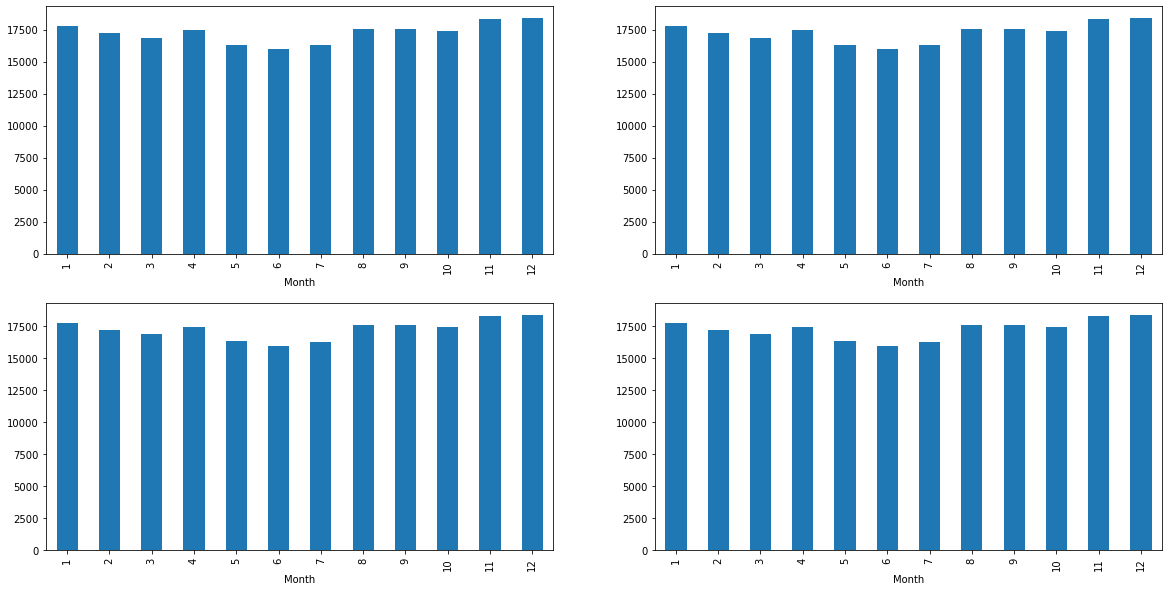

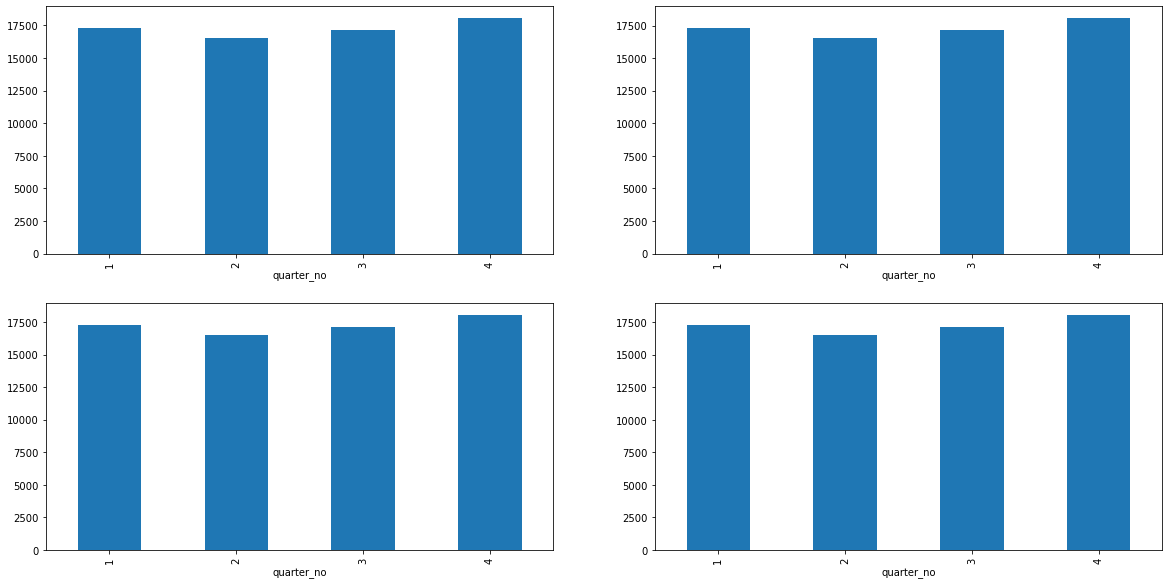

In [17]:
data_grouped = data_NSEI.groupby('Month').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
plt.show()
data_grouped = data_NSEI.groupby('quarter_no').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
plt.show()

##### Observations:
- We can see that the OHLC values remains almost constant throught the year only decreases in midst of the year

In [18]:
data_NSEI.groupby('is_quarter_end').mean()

Open          High           Low         Close  \
is_quarter_end                                                           
0               17273.200406  17276.911489  17269.329996  17273.101106   
1               17191.108057  17194.985865  17187.016930  17190.975294   

                     ATR  Biweekly Number    Pivot_mean  Resistance_1_mean  \
is_quarter_end                                                               
0               7.868018        12.271833  17273.093065       17276.878074   
1               8.240338        15.646255  17190.992696       17194.968463   

                Support_1_mean  Resistance_2_mean  ...     R1-S1      R2-S2  \
is_quarter_end                                     ...                        
0                 17269.295351       17280.675787  ...  7.582722  15.165444   
1                 17186.999528       17198.961631  ...  7.968935  15.937869   

                    R3-S3          lag1          lag2          lag3  \
is_quarter_end                                                        
0               22.748166  17273.065800  17273.030122  17272.994049   
1               23.906804  17191.020338  17191.065747  17191.111849   

                        lag4           MA1           MA2           MA3  
is_quarter_end                                                          
0               17272.957928  17273.101106  17273.083453  17273.065676  
1               17191.157251  17190.975294  17190.997816  17191.020460  

[2 rows x 30 columns]

##### Observations:
- Prices and also the volatility (ATR) values are higher in the months which are quarter end as compared to that of the non-quarter end months.

In [19]:
data_sp = data_NSEI

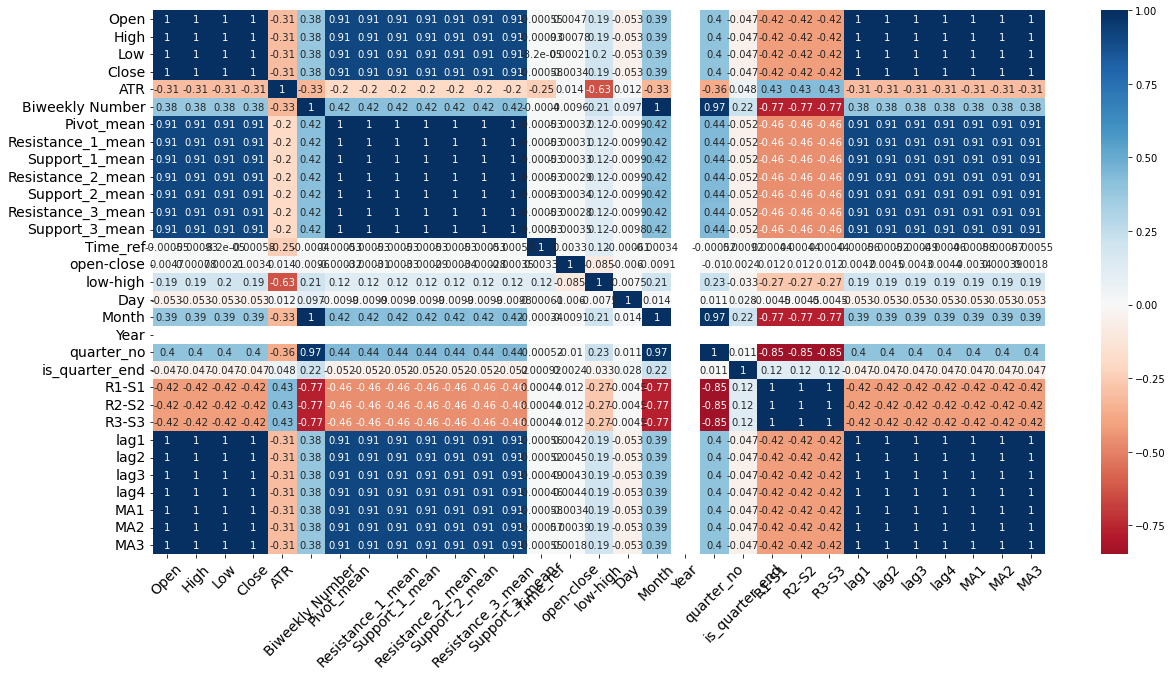

In [20]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_NSEI.corr(), annot=True,cmap='RdBu',center=0)
plt.xticks(fontsize=14,rotation=45)
plt.yticks(fontsize=14)
plt.show()

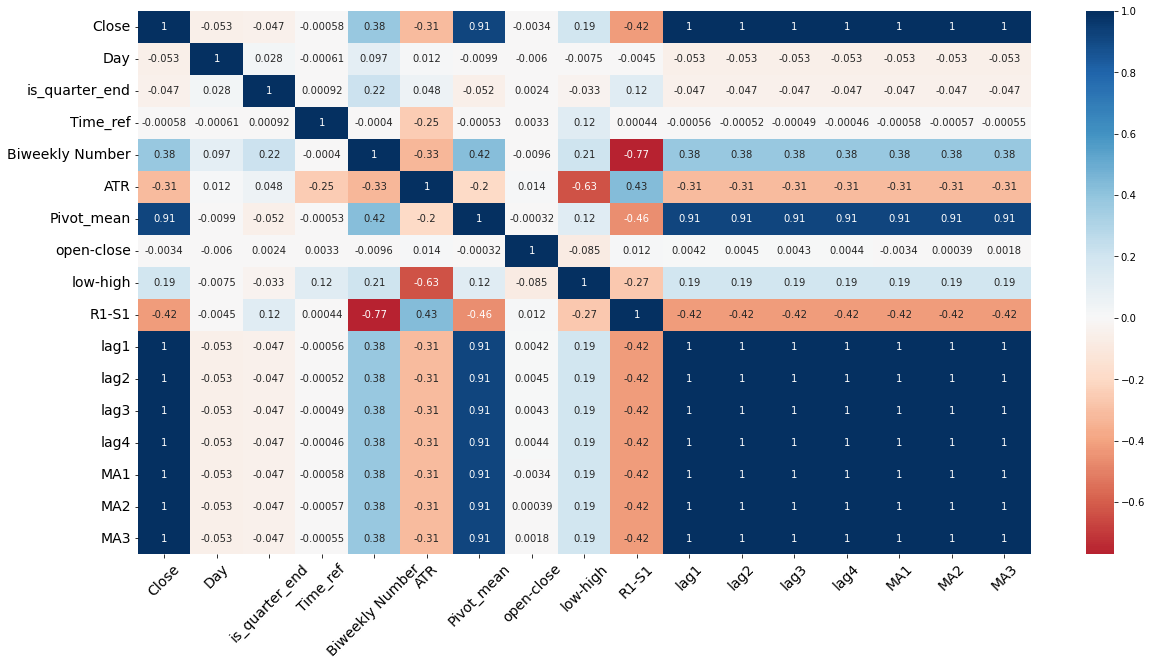

In [22]:
data_NSEI = data_NSEI[['Close','Day', 'is_quarter_end','Time_ref','Biweekly Number',
                             'ATR', 'Pivot_mean', 'open-close','low-high', 'R1-S1','lag1','lag2','lag3'
                            ,'lag4','MA1','MA2','MA3']]
plt.figure(figsize=(20, 10))
sns.heatmap(data_NSEI.corr(), annot=True,cmap='RdBu',center=0)
plt.xticks(fontsize=14,rotation=45)
plt.yticks(fontsize=14,rotation=0)
plt.show()

In [23]:
df_train = data_NSEI['2022-01-03 09:15:00':'2022-11-30 15:30:00']
df_test = data_NSEI['2022-12-01 09:15:00':'2022-12-31 15:30:00']

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\HP\AppData\Local\Temp\ipykernel_11540\3614296746.py:39: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Train RMSE: 17028.245520650646
Validation RMSE: 18290.2859284859
Test RMSE: 18386.35763929809


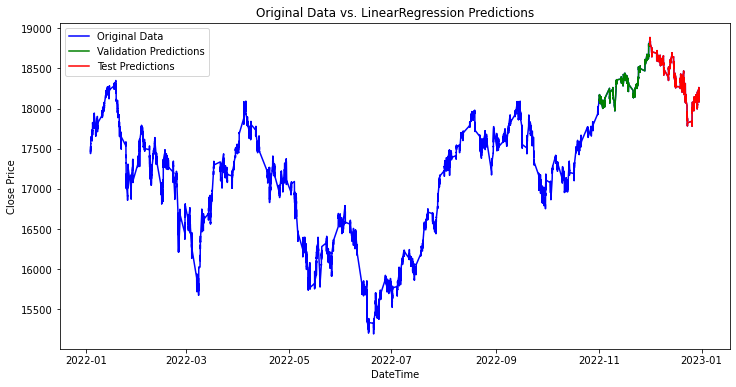

Train RMSE: 17031.512805140508
Validation RMSE: 17688.43892713922
Test RMSE: 17672.734778551185


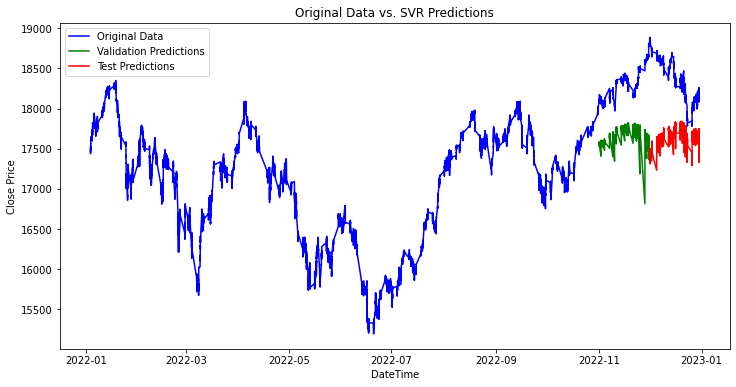

Train RMSE: 17028.24329910174
Validation RMSE: 18231.75251958513
Test RMSE: 18241.809741445133


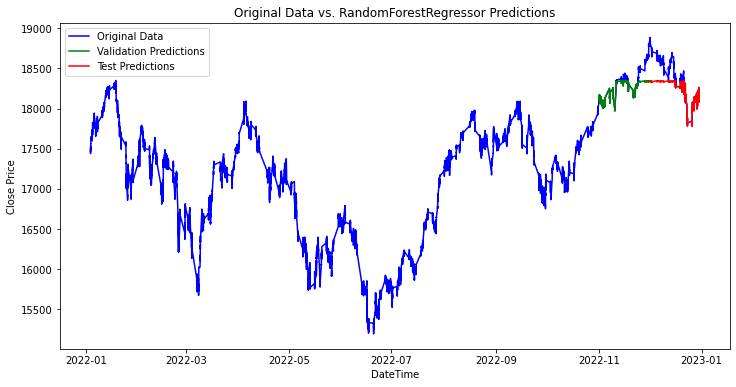

In [24]:
from sklearn.preprocessing import StandardScaler
# Load your data into a DataFrame
data = data_NSEI

# Set the random seed for reproducibility
np.random.seed(42)

features = ['Close','Day', 'is_quarter_end','Time_ref','Biweekly Number','ATR',
            'Pivot_mean', 'open-close','low-high', 'R1-S1','lag1','lag2','lag3'
            ,'lag4','MA1','MA2','MA3']
target = ['Close']

# Split the data sequentially
train_data = data.loc['2022-01-03 09:15:00':'2022-10-31 15:30:00']
validation_data = data.loc['2022-11-01 09:15:00':'2022-11-30 15:30:00']
test_data = data.loc['2022-12-01 09:15:00':'2022-12-31 15:30:00']

# Feature scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(train_data[features])
X_valid = scaler_x.transform(validation_data[features])
X_test = scaler_x.transform(test_data[features])

Y_train = scaler_y.fit_transform(train_data[target])
Y_valid = scaler_y.transform(validation_data[target])
Y_test = scaler_y.transform(test_data[target])

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

models = [LinearRegression(), SVR(kernel='rbf', C=1.0, gamma='scale'),
          RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_leaf=1)]

for model in models:
    model.fit(X_train, Y_train)

for model in models:
    # Make predictions
    train_predictions = model.predict(X_train)
    validation_predictions = model.predict(X_valid)
    test_predictions = model.predict(X_test)
    
        # Inside the loop after making predictions for each model
    train_predictions = train_predictions.reshape(-1, 1)
    validation_predictions = validation_predictions.reshape(-1, 1)
    test_predictions = test_predictions.reshape(-1, 1)

    # inverse transformation to get original values
    train_predictions = scaler_y.inverse_transform(train_predictions)
    validation_predictions = scaler_y.inverse_transform(validation_predictions)
    test_predictions = scaler_y.inverse_transform(test_predictions)

    # Evaluate the model
    train_rmse = np.sqrt(mean_squared_error(Y_train, train_predictions))
    validation_rmse = np.sqrt(mean_squared_error(Y_valid, validation_predictions))
    test_rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))

    print(f"Train RMSE: {train_rmse}")
    print(f"Validation RMSE: {validation_rmse}")
    print(f"Test RMSE: {test_rmse}")

    # Plot original data vs. predictions
    model_name = str(model.__class__).split('.')[-1][:-2] 
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Original Data', color='blue')
    plt.plot(validation_data.index, validation_predictions, label='Validation Predictions', color='green')
    plt.plot(test_data.index, test_predictions, label='Test Predictions', color='red')
    plt.legend()
    plt.xlabel('DateTime')
    plt.ylabel('Close Price')
    plt.title(f'Original Data vs. {model_name} Predictions')
    plt.show()



Epoch 1/2
2392/2392 [==============================] - 24s 10ms/step - loss: 0.0181 - val_loss: 2.9845e-04
Epoch 2/2
259/259 [==============================] - 1s 3ms/step
Train RMSE: 17024.845359703013
Validation RMSE: 18280.372661686797
Test RMSE: 18376.5025267111


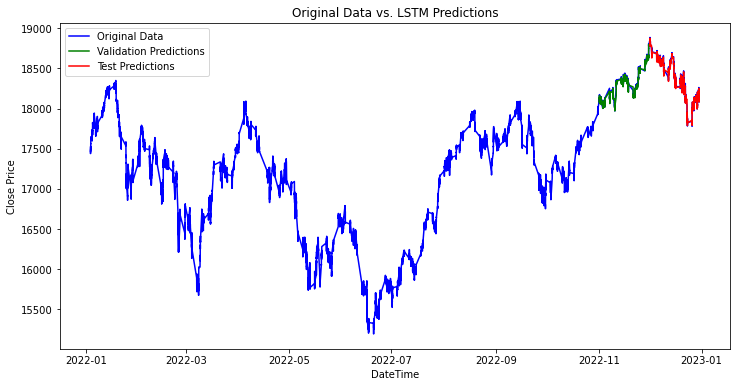

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

data = data_NSEI
np.random.seed(42)

features = ['Close','Day', 'is_quarter_end','Time_ref','Biweekly Number',
            'ATR', 'Pivot_mean', 'open-close','low-high', 'R1-S1','lag1','lag2','lag3'
            ,'lag4','MA1','MA2','MA3']
target = ['Close']

# Split the data sequentially
train_data = data.loc['2022-01-03 09:15:00':'2022-10-31 15:30:00']
validation_data = data.loc['2022-11-01 09:15:00':'2022-11-30 15:30:00']
test_data = data.loc['2022-12-01 09:15:00':'2022-12-31 15:30:00']

# Feature scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(train_data[features])
X_valid = scaler_x.transform(validation_data[features])
X_test = scaler_x.transform(test_data[features])

Y_train = scaler_y.fit_transform(train_data[target])
Y_valid = scaler_y.transform(validation_data[target])
Y_test = scaler_y.transform(test_data[target])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=10, return_sequences=False, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=2, batch_size=32, validation_data=(X_valid,Y_valid))

# Make predictions
train_predictions = model.predict(X_train)
validation_predictions = model.predict(X_valid)
test_predictions = model.predict(X_test)

train_predictions = scaler_y.inverse_transform(train_predictions)
validation_predictions = scaler_y.inverse_transform(validation_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predictions))
validation_rmse = np.sqrt(mean_squared_error(Y_valid, validation_predictions))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))

print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {validation_rmse}")
print(f"Test RMSE: {test_rmse}")

# Plot the original data vs. predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Original Data', color='blue')
plt.plot(validation_data.index, validation_predictions, label='Validation Predictions', color='green')
plt.plot(test_data.index, test_predictions, label='Test Predictions', color='red')
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.title('Original Data vs. LSTM Predictions')
plt.show()


Epoch 1/2
2392/2392 [==============================] - 24s 9ms/step - loss: 0.0285 - val_loss: 7.6600e-04
Epoch 2/2
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step
Test RMSE: 16723.267617476195


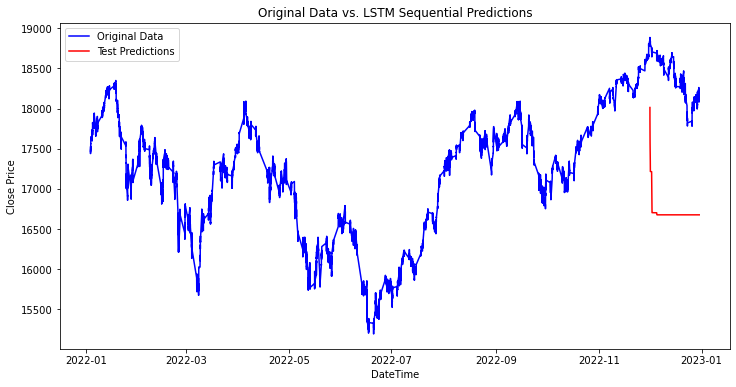

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

data = data_NSEI
np.random.seed(42)

features = ['Close','Day', 'is_quarter_end','Time_ref','Biweekly Number',
                             'ATR', 'Pivot_mean', 'open-close','low-high', 'R1-S1','lag1','lag2','lag3'
                            ,'lag4','MA1','MA2','MA3']
target = ['Close']

# Split the data sequentially
train_data = data.loc['2022-01-03 09:15:00':'2022-10-31 15:30:00']
validation_data = data.loc['2022-11-01 09:15:00':'2022-11-30 15:30:00']
test_data = data.loc['2022-12-01 09:15:00':'2022-12-31 15:30:00']

# Feature scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(train_data[features])
X_valid = scaler_x.transform(validation_data[features])
X_test = scaler_x.transform(test_data[features])

Y_train = scaler_y.fit_transform(train_data[target])
Y_valid = scaler_y.transform(validation_data[target])
Y_test = scaler_y.transform(test_data[target])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=10, return_sequences=False, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=2, batch_size=32, validation_data=(X_valid,Y_valid))

predictions = []
# Initialize a window with the last sequence from the training data
window = X_train[-1]
# Define the number of future predictions you want
num_predictions = len(X_test)

# Generate predictions sequentially
for _ in range(num_predictions):
    # Predict the next value based on the current window
    next_value = model.predict(np.array([window]))[0][0] 
    # Append the predicted value to the list of predictions
    predictions.append(next_value)
    # Slide the window by one time step and update it with the predicted value
    window = np.roll(window, -1)
    window[-1] = next_value

# inverse transformation to get original values
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

# Evaluate the model
test_rmse = np.sqrt(mean_squared_error(Y_test, predictions))

print(f"Test RMSE: {test_rmse}")

# Plot the original data vs. predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Original Data', color='blue')
plt.plot(test_data.index, predictions, label='Test Predictions', color='red')
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.title('Original Data vs. LSTM Sequential Predictions')
plt.show()


Epoch 1/5
2392/2392 [==============================] - 18s 7ms/step - loss: 0.0882 - val_loss: 0.0330
Epoch 2/5
2392/2392 [==============================] - 16s 7ms/step - loss: 0.0218 - val_loss: 0.0187
Epoch 3/5
2392/2392 [==============================] - 16s 7ms/step - loss: 0.0177 - val_loss: 0.0161
Epoch 4/5
2392/2392 [==============================] - 16s 7ms/step - loss: 0.0167 - val_loss: 0.0211
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


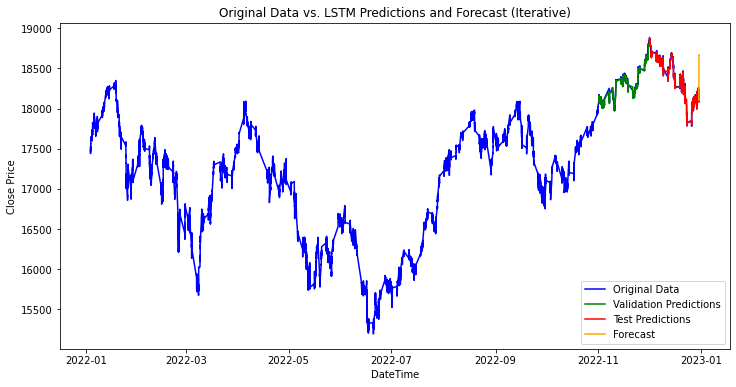

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = data_NSEI
np.random.seed(42)

features = ['Day', 'is_quarter_end', 'Time_ref', 'Biweekly Number', 'ATR',
       'Pivot_mean', 'open-close', 'low-high', 'R1-S1', 'lag1', 'lag2', 'lag3', 'lag4']
target = ['Close']

# Split the data sequentially
train_data = data.loc['2022-01-03 09:15:00':'2022-10-31 15:30:00']
validation_data = data.loc['2022-11-01 09:15:00':'2022-11-30 15:30:00']
test_data = data.loc['2022-12-01 09:15:00':'2022-12-31 15:30:00']

# Feature scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_x.fit_transform(train_data[features])
X_valid = scaler_x.transform(validation_data[features])
X_test = scaler_x.transform(test_data[features])

Y_train = scaler_y.fit_transform(train_data[target])
Y_valid = scaler_y.transform(validation_data[target])
Y_test = scaler_y.transform(test_data[target])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=3, return_sequences=False, input_shape=(X_train.shape[1], 1), activation='relu'))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_valid, Y_valid))

# Prepare input data for forecasting
input_data = X_test[-1].reshape(1, -1, 1)
forecasted_values = []
for _ in range(360):
    # Predict the next value based on the last input
    next_prediction = model.predict(input_data.reshape(1, -1, 1))    
    # Store the prediction
    forecasted_values.append(next_prediction[0, 0])
    # Update the input data for the next prediction
    input_data = np.append(input_data[:, 1:], next_prediction.reshape(1, 1, 1), axis=1)

    # Update the input data with the most recent prediction
    input_data[-1] = next_prediction
    
forecasted_values = scaler_y.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

forecast_index = pd.date_range(start=test_data.index[-1], periods=360, freq='T')  # Adjust the frequency as needed

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(data=forecasted_values, index=forecast_index, columns=['Forecast'])

# Plot the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Original Data', color='blue')
plt.plot(validation_data.index, validation_predictions, label='Validation Predictions', color='green')
plt.plot(test_data.index, test_predictions, label='Test Predictions', color='red')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='orange')
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.title('Original Data vs. LSTM Predictions and Forecast (Iterative)')
plt.show()


Epoch 1/5
2392/2392 [==============================] - 8s 3ms/step - loss: 0.2941 - val_loss: 0.0015
Epoch 2/5
2392/2392 [==============================] - 6s 3ms/step - loss: 0.0564 - val_loss: 0.0016
Epoch 3/5
2392/2392 [==============================] - 6s 3ms/step - loss: 0.0227 - val_loss: 0.0014
Epoch 4/5
2392/2392 [==============================] - 7s 3ms/step - loss: 0.0121 - val_loss: 3.5122e-04
Epoch 5/5
1/1 [==============================] - 0s 38ms/step


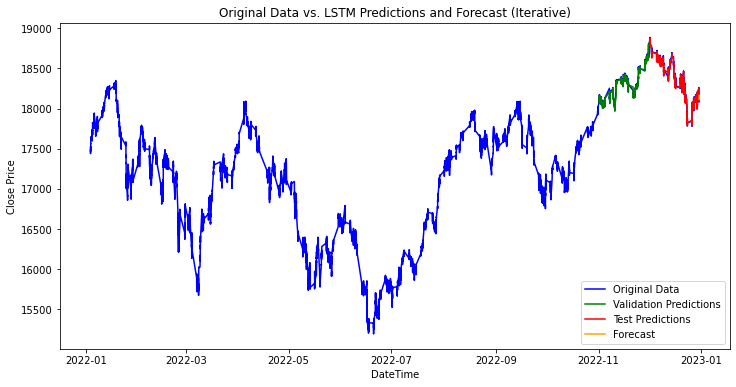

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = data_NSEI
np.random.seed(42)

# Select the target column
target_column = ['Close']

# Split the data sequentially
train_data = data.loc['2022-01-03 09:15:00':'2022-10-31 15:30:00']
validation_data = data.loc['2022-11-01 09:15:00':'2022-11-30 15:30:00']
test_data = data.loc['2022-12-01 09:15:00':'2022-12-31 15:30:00']

# Feature scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(train_data[target_column])
X_valid = scaler.transform(validation_data[target_column])
X_test = scaler.transform(test_data[target_column])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=3, return_sequences=False, input_shape=(X_train.shape[1], 1), activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X_train, X_train, epochs=5, batch_size=32, validation_data=(X_valid, X_valid))

# Prepare input data for forecasting
input_data = X_test[-1].reshape(1, -1, 1)
# Forecast the next 24 observations iteratively
forecasted_values = []
for _ in range(60):
    # Predict the next value based on the last input
    next_prediction = model.predict(input_data.reshape(1, -1, 1))    
    # Store the prediction
    forecasted_values.append(next_prediction[0, 0])
    # Update the input data for the next prediction
    input_data = np.append(input_data[:, 1:], next_prediction.reshape(1, 1, 1), axis=1)
    # Update the input data with the most recent prediction
    input_data[-1] = next_prediction
    
# Inverse transform the predicted values to get the original scale
forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

# Create a time index for the forecasted values
forecast_index = pd.date_range(start=test_data.index[-1], periods=60, freq='T') 

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(data=forecasted_values, index=forecast_index, columns=['Forecast'])

# Plot the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Original Data', color='blue')
plt.plot(validation_data.index, validation_predictions, label='Validation Predictions', color='green')
plt.plot(test_data.index, test_predictions, label='Test Predictions', color='red')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='orange')
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.title('Original Data vs. LSTM Predictions and Forecast (Iterative)')
plt.show()


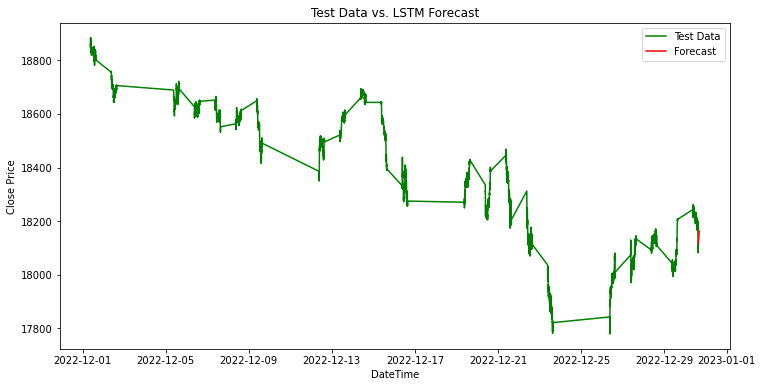

In [29]:
# Plot the original data and forecasted values for the test period
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='green')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.legend()
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.title('Test Data vs. LSTM Forecast')
plt.show()

In [36]:
from sklearn.cluster import KMeans
import pandas as pd

data = data_sp[['Open','High','Low','Close']]

clusters = {}

for date, day_data in data.groupby(data.index.date):
    kmeans = KMeans(n_clusters=2)
    day_data = day_data[['Low', 'High']]
    kmeans.fit(day_data)
    clusters[date] = kmeans.cluster_centers_.flatten()

new_data = []
date_index = []
for date, day_data in data.groupby(data.index.date):
    date_index.append(date)
    new_row = {
        "Open": day_data.iloc[0]['Open'],
        "High": day_data['High'].max(),
        "Low": day_data['Low'].min(),
        "Close": day_data.iloc[-1]['Close'],
        "Support": clusters[date][0],
        "Resistance": clusters[date][1]
    }
    new_data.append(new_row)
new_data = pd.DataFrame(new_data,index=date_index)

In [37]:
data_sp['Date'] = data_sp.index.date
new_data = new_data.join(data_sp.set_index('Date'),rsuffix='_sp')[['Open', 'High', 'Low', 'Close', 'ATR', 'Biweekly Number',
       'Pivot_mean', 'Resistance_1_mean', 'Support_1_mean',
       'Resistance_2_mean', 'Support_2_mean', 'Resistance_3_mean',
       'Support_3_mean', 'Time_ref', 'open-close', 'low-high', 'Day', 'Month',
       'Year', 'quarter_no', 'is_quarter_end', 'R1-S1', 'R2-S2', 'R3-S3',
       'lag1', 'lag2', 'lag3', 'lag4', 'MA1', 'MA2', 'MA3','Support','Resistance']]
new_data.index = data_sp.index

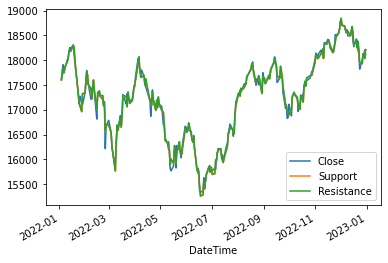

In [38]:
new_data['Close'].plot()
new_data['Support'].plot()
new_data['Resistance'].plot()
plt.legend()
plt.show()

In [39]:
x = new_data.groupby('Biweekly Number').mean()[['Support','Resistance']]
new_data = new_data.join(x,on='Biweekly Number',rsuffix='_sp')

In [40]:
new_data.columns

Index(['Open', 'High', 'Low', 'Close', 'ATR', 'Biweekly Number', 'Pivot_mean',
       'Resistance_1_mean', 'Support_1_mean', 'Resistance_2_mean',
       'Support_2_mean', 'Resistance_3_mean', 'Support_3_mean', 'Time_ref',
       'open-close', 'low-high', 'Day', 'Month', 'Year', 'quarter_no',
       'is_quarter_end', 'R1-S1', 'R2-S2', 'R3-S3', 'lag1', 'lag2', 'lag3',
       'lag4', 'MA1', 'MA2', 'MA3', 'Support', 'Resistance', 'Support_sp',
       'Resistance_sp'],
      dtype='object')

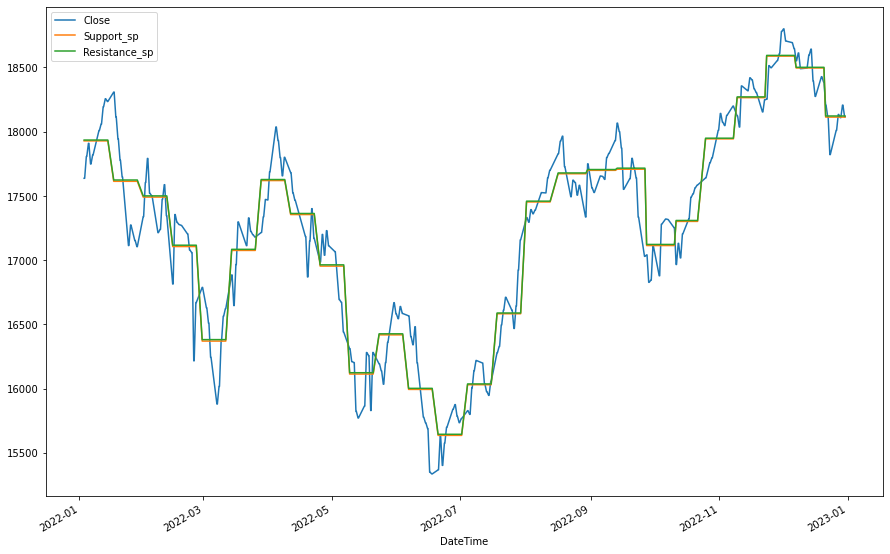

In [41]:
plt.figure(figsize=(15,10))
plt
new_data['Close'].plot()
new_data['Support_sp'].plot()
new_data['Resistance_sp'].plot()
# new_data['Resistance_3_mean'].plot()
# new_data['Support_3_mean'].plot()

plt.legend()
plt.show()

In [42]:
from sklearn.cluster import KMeans
import pandas as pd

data = data_sp[['Open','High','Low','Close']]

clusters = {}

for date, day_data in data.groupby(data.index.date):
    kmeans = KMeans(n_clusters=6)  # Update to 6 clusters
    day_data = day_data[['Low', 'High']]
    kmeans.fit(day_data)
    clusters[date] = kmeans.cluster_centers_.flatten()

new_data = []
date_index = []
for date, day_data in data.groupby(data.index.date):
    date_index.append(date)
    new_row = {
        "Open": day_data.iloc[0]['Open'],
        "High": day_data['High'].max(),
        "Low": day_data['Low'].min(),
        "Close": day_data.iloc[-1]['Close'],
        "Cluster 1": clusters[date][0], 
        "Cluster 2": clusters[date][1],
        "Cluster 3": clusters[date][2],
        "Cluster 4": clusters[date][3],
        "Cluster 5": clusters[date][4],
        "Cluster 6": clusters[date][5]
    }
    new_data.append(new_row)
new_data = pd.DataFrame(new_data, index=date_index)


In [43]:
data_sp['Date'] = data_sp.index.date
new_data = new_data.join(data_sp.set_index('Date'),rsuffix='_sp')[['Open', 'High', 'Low', 'Close', 'ATR', 'Biweekly Number',
       'Pivot_mean', 'Resistance_1_mean', 'Support_1_mean',
       'Resistance_2_mean', 'Support_2_mean', 'Resistance_3_mean',
       'Support_3_mean', 'Time_ref', 'open-close', 'low-high', 'Day', 'Month',
       'Year', 'quarter_no', 'is_quarter_end', 'R1-S1', 'R2-S2', 'R3-S3',
       'lag1', 'lag2', 'lag3', 'lag4', 'MA1', 'MA2', 'MA3','Cluster 1','Cluster 2','Cluster 3',
                                                                  'Cluster 4','Cluster 5','Cluster 6']]
new_data.index = data_sp.index

In [44]:
x = new_data.groupby('Biweekly Number').mean()[['Cluster 1','Cluster 2','Cluster 3',
                                                'Cluster 4','Cluster 5','Cluster 6']]
new_data = new_data.join(x,on='Biweekly Number',rsuffix='_sp')

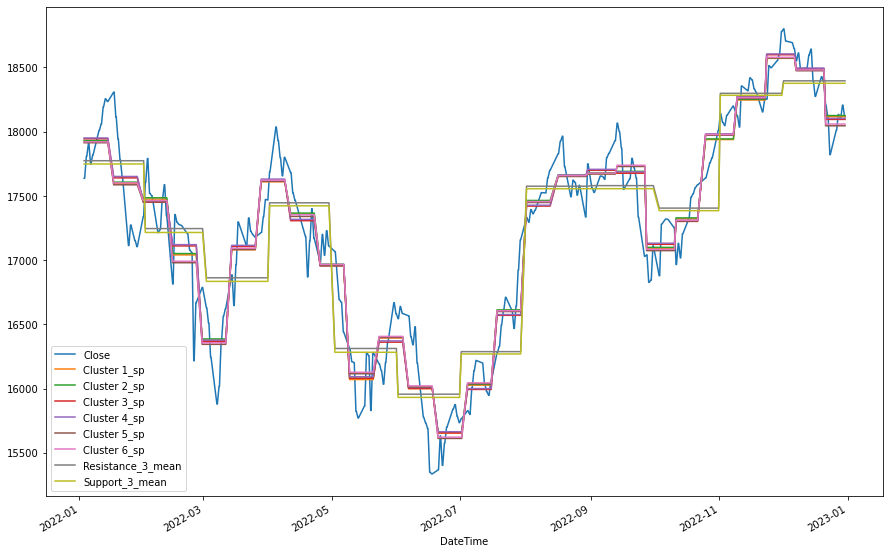

In [45]:
plt.figure(figsize=(15,10))
plt
new_data['Close'].plot()
new_data['Cluster 1_sp'].plot()
new_data['Cluster 2_sp'].plot()
new_data['Cluster 3_sp'].plot()
new_data['Cluster 4_sp'].plot()
new_data['Cluster 5_sp'].plot()
new_data['Cluster 6_sp'].plot()
new_data['Resistance_3_mean'].plot()
new_data['Support_3_mean'].plot()

plt.legend()
plt.show()